# Music 103 diffusion version

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import numpy as np
import copy
import pandas as pd
from tqdm import tqdm
from os.path import exists
from os import remove, chdir
import pickle

In [51]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output
    
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model

    def forward(self, x):
        max_len = x.size(1)
        pe = torch.zeros(max_len, self.d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * -(math.log(10000.0) / self.d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0).to(x.device)
        return x + pe


class DecoderPositionalEncoding(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model

    def forward(self, x, tgt):
        # max_len = x.size(1)
        tgt_one_hot = tgt[:, :, 12:]
        tgt_class = torch.argmax(tgt_one_hot, dim=-1)
        pe = torch.zeros_like(x)
        position = torch.cumsum(tgt_class, dim=1).unsqueeze(-1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * -(math.log(10000.0) / self.d_model)).to(position.device)
        
        pe[:, :, 0::2] = torch.sin(position * div_term)
        pe[:, :, 1::2] = torch.cos(position * div_term)
        return x + pe

    
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

class EmbedHead(nn.Module):
    def __init__(
        self,
        input_dim,
        inner_dim_1,
        inner_dim_2,
        out_dim
    ):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, inner_dim_1)
        self.linear2 = nn.Linear(inner_dim_1, inner_dim_2)
        self.linear3 = nn.Linear(inner_dim_2, out_dim)
        self.activation_fn = nn.functional.gelu

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation_fn(x)
        x = self.linear2(x)
        x = self.activation_fn(x)
        x = self.linear3(x)
        return x
    

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = EmbedHead(src_vocab_size, d_model, d_model, d_model)
        self.decoder_embedding = EmbedHead(tgt_vocab_size, d_model, d_model, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.time_embeddings = nn.ModuleList([EmbedFC(1, d_model) for _ in range(num_layers)])
        self.decoder_positional_encoding = PositionalEncoding(d_model)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        return torch.ones_like(src).bool(), torch.ones_like(tgt).bool()

    def forward(self, src, tgt, time):
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, None)

        dec_output = tgt_embedded
        for i, dec_layer in enumerate(self.decoder_layers):
            dec_output = dec_layer(dec_output, enc_output, None, None)
            time_embedding = self.time_embeddings[i](time).unsqueeze(1)
            dec_output = dec_output + time_embedding

        output = self.fc(dec_output)
        return output


# **1. DDPM**


# a. Building Blocks

In [ ]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.same_channels = in_channels==out_channels
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
          x1 = self.conv1(x)
          x2 = self.conv2(x1)
          if self.same_channels:
              out = x + x2
          else:
              out = x1 + x2
          return out / 1.414


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()
        layers = [ResidualConvBlock(in_channels, out_channels), nn.MaxPool2d(2)]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ContextUnet(nn.Module):
    def __init__(self, in_channels, n_feat = 256, n_classes=10):
        super(ContextUnet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes

        self.init_conv = ResidualConvBlock(in_channels, n_feat)

        self.down1 = UnetDown(n_feat, n_feat)
        self.down2 = UnetDown(n_feat, 2 * n_feat)

        self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())

        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_classes, 2*n_feat)
        self.contextembed2 = EmbedFC(n_classes, 1*n_feat)

        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, 7, 7),
            nn.GroupNorm(8, 2 * n_feat),
            nn.ReLU(),
        )

        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat),
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        )

    def forward(self, x, c, t, context_mask):
        x = self.init_conv(x)
        down1 = self.down1(x)
        down2 = self.down2(down1)
        hiddenvec = self.to_vec(down2)

        c = nn.functional.one_hot(c, num_classes=self.n_classes).type(torch.float)

        context_mask = context_mask[:, None]
        context_mask = context_mask.repeat(1,self.n_classes)
        context_mask = (-1*(1-context_mask)) # need to flip 0 <-> 1
        c = c * context_mask

        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)

        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1+ temb1, down2)
        up3 = self.up2(cemb2*up2+ temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

# b. DDPM Schedules

In [4]:
def ddpm_schedules(beta1, beta2, T):
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    ##################
    ### Problem 1 (a): Implement ddpm_schedules()
    beta_t = torch.linspace(beta1, beta2, T).float()

    alpha_t = 1 - beta_t
    oneover_sqrta = 1 / torch.sqrt(alpha_t)
    sqrt_beta_t = torch.sqrt(beta_t)
    alphabar_t = torch.cumprod(alpha_t, dim=0)
    sqrtab = torch.sqrt(alphabar_t)
    sqrtmab = torch.sqrt(1 - alphabar_t)
    mab_over_sqrtmab_inv = (1 - alpha_t) / torch.sqrt(1 - alphabar_t)
    ##################
    ##################

    return {
        "alpha_t": alpha_t,  # \alpha_t
        "oneover_sqrta": oneover_sqrta,  # 1/\sqrt{\alpha_t}
        "sqrt_beta_t": sqrt_beta_t,  # \sqrt{\beta_t}
        "alphabar_t": alphabar_t,  # \bar{\alpha_t}
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
        "mab_over_sqrtmab": mab_over_sqrtmab_inv,  # (1-\alpha_t)/\sqrt{1-\bar{\alpha_t}}
    }

# c. DDPM Main Module



Here the noise $\sigma_t^2=\beta_t$

In [54]:
class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device, n_inference=None, drop_prob=0.1):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)
        
        self.n_T = n_T
        self.n_inference = n_inference if n_inference else n_T 
        
        for k, v in ddpm_schedules(betas[0], betas[1], self.n_inference).items():
            self.register_buffer(k+'_KAIMING', v)

        self.device = device
        self.drop_prob = drop_prob
        self.loss_mse = nn.MSELoss()

    def forward(self, src, tgt):
        ##################
        ### Problem 1 (b): Implement forward()
        t = torch.randint(0, self.n_T, (tgt.size(0),), device=self.device)
        sqrtab_t, sqrtmab_t = self.sqrtab[t].view(-1, 1, 1), \
            self.sqrtmab[t].view(-1, 1, 1)

        noise = torch.randn_like(tgt).to(self.device)  # Define noise tensor
        x_t = sqrtab_t * tgt + sqrtmab_t * noise

        # mask out with probability
        context_mask = torch.bernoulli(torch.zeros(src.shape[0])+self.drop_prob).unsqueeze(-1).unsqueeze(-1).to(self.device)

        pred_noise = self.nn_model(src * context_mask, x_t, t / self.n_T)
        loss = self.loss_mse(pred_noise, noise)
        ##################
        ##################

        return loss

    @torch.no_grad()
    def sample(self, src, guide_w=0.0):
        n_sample = src.shape[0]
        x_i = torch.randn(*src.shape).to(self.device)
        c_i = src.to(self.device).clone()
        c_i = c_i.repeat(2, 1, 1)
        context_mask = torch.zeros_like(c_i).to(self.device)
        context_mask[n_sample:] = 1.0  # second half context-free

        for i in range(int(self.n_inference), 0, -1):
            if guide_w > 1.5 and (i - 1) % 200 == 0:
                print(f'Sampling timestep {i - 1}')

            ##################
            ### Problem 1 (c): Implement sample()
            t = torch.full((n_sample,), (i - 1) / self.n_inference).to(self.device).float()
            t_i = t.view(-1, 1, 1)

            # double batch
            x_i = x_i.repeat(2, 1, 1)
            t_i = t_i.repeat(2, 1, 1)

            z = torch.randn(*src.shape).to(self.device) if i > 1 else 0 # if last step, no noise
            # classifier-free guidance
            pred_full = self.nn_model(c_i * context_mask, x_i, t_i)
            pred_1, pred_2 = pred_full[:n_sample], pred_full[n_sample:]
            pred_noise = (1 + guide_w) * pred_1 - guide_w * pred_2
            x_i = x_i[:n_sample]
            x_i = self.oneover_sqrta_KAIMING[i - 1] * (x_i - pred_noise * self.mab_over_sqrtmab_KAIMING[i - 1])\
                + self.sqrt_beta_t_KAIMING[i - 1] * z
        return x_i

# c. Training Function

In [61]:
from tqdm import tqdm

def train_main_loop(ddpm, optim, trainset, testset, lr, n_epoch, device, guide_w):
    for ep in tqdm(range(n_epoch)):
        ddpm.train()

        # linear lrate decay
        optim.param_groups[0]['lr'] = lr*(1-ep/n_epoch)
        loss_ema = None
        # train
        for idx, src, tgt in trainset:
            optim.zero_grad()
            tgt = tgt.to(device)
            src = src.to(device)
            loss = ddpm(src, tgt)
            loss.backward()
            if loss_ema is None:
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            #pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()
        print(f'epoch {ep}, loss: {loss_ema:.4f}')
        if (ep + 1) % 10 == 0:
            torch.save(ddpm.nn_model, f"model_{ep + 1}_diffusion.pt")

    # eval
    ddpm.eval()
    x_gens = []
    count = 0
    with torch.no_grad():
        for idx, src, tgt in tqdm(testset, total=len(testset)):
            if count > 3:
                break
            x_gens.append((idx, (ddpm.sample(src, guide_w) >= 0.5).long()))
            count += 1

    torch.save(x_gens, "song_test_music103.pt")



In [21]:
import pickle
trainset = pickle.load(open("/home/vipandyc/data1/6.S978/music102/POP909/model_train/trainset_w.pkl", "rb"))

# e. Training


In [ ]:
# hardcoding these here
n_epoch = 100
n_T = 1000
n_feat = 128
lr = 1e-4
ws_test = [0.0, 0.5, 2.0]
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

chdir("/home/vipandyc/data1/6.S978/music102/POP909/model_train")
src_vocab_size = 12
tgt_vocab_size = 12
d_model = 512
num_heads = 8
num_layers = 4
d_ff = 4096//8
max_seq_length = 2400
dropout = 0.1
batchsize = 16
mode = "train"


if exists("trainset_w.pkl") and exists("validset_w.pkl") and exists("testset_w.pkl"):
    print("splitted dataset found!")
    with open("trainset_w.pkl", "rb") as f:
        trainset = pickle.load(f)
    with open("validset_w.pkl", "rb") as f:
        validset = pickle.load(f)
    with open("testset_w.pkl", "rb") as f:
        testset = pickle.load(f)
else:
    print("?")

def collate_fn(batch):
    # Unpack batch into individual components
    idx, src_data, tgt_data, w = zip(*batch)
    #print(len(rates[0]), len(tgt_data[0]), len(src_data[0]))
    
    # Convert `src_data`, `tgt_data`, and `rates` to tensors if they are not already
    src_data = [torch.tensor(s, dtype=torch.float32) if not isinstance(s, torch.Tensor) else s for s in src_data]
    tgt_data = [torch.tensor(t, dtype=torch.float32) if not isinstance(t, torch.Tensor) else t for t in tgt_data]

    src_data = [torch.cat([s], dim=-1) for s in src_data]
    tgt_data = [torch.cat([t], dim=-1) for t in tgt_data]

    # Pad src_data
    src_data = nn.utils.rnn.pad_sequence(src_data, batch_first=True, padding_value=0.).to(DEVICE)

    # Pad tgt_data
    tgt_data = nn.utils.rnn.pad_sequence(tgt_data, batch_first=True, padding_value=0).to(DEVICE)

    # Extract the last dimension and one-hot encode it
    return idx, src_data, tgt_data


trainset = data.DataLoader(trainset, batch_size=batchsize, collate_fn=collate_fn)
validset = data.DataLoader(validset, batch_size=1, collate_fn=collate_fn)
testset = data.DataLoader(testset, batch_size=1, collate_fn=collate_fn)

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout).to(DEVICE)

ddpm = DDPM(nn_model=transformer, betas=(1e-4, 0.02), n_T=n_T, \
    device=DEVICE, n_inference=1000, drop_prob=0.1)
ddpm.to(DEVICE)

optim = torch.optim.Adam(ddpm.parameters(), lr=lr)
train_main_loop(ddpm, optim, trainset, testset, lr, n_epoch, DEVICE, 2)


splitted dataset found!


  1%|          | 1/100 [00:09<16:07,  9.77s/it]

epoch 0, loss: 0.9543


  2%|▏         | 2/100 [00:19<16:05,  9.85s/it]

epoch 1, loss: 0.3395


  3%|▎         | 3/100 [00:29<15:58,  9.88s/it]

epoch 2, loss: 0.1712


  4%|▍         | 4/100 [00:39<15:53,  9.93s/it]

epoch 3, loss: 0.1609


  5%|▌         | 5/100 [00:49<15:47,  9.97s/it]

epoch 4, loss: 0.1766


  6%|▌         | 6/100 [00:59<15:40, 10.01s/it]

epoch 5, loss: 0.1358


  7%|▋         | 7/100 [01:09<15:35, 10.06s/it]

epoch 6, loss: 0.1392


  8%|▊         | 8/100 [01:20<15:27, 10.08s/it]

epoch 7, loss: 0.1609


  9%|▉         | 9/100 [01:30<15:19, 10.10s/it]

epoch 8, loss: 0.1440


 10%|█         | 10/100 [01:40<15:13, 10.15s/it]

epoch 9, loss: 0.1429


 11%|█         | 11/100 [01:50<15:03, 10.15s/it]

epoch 10, loss: 0.1374


 12%|█▏        | 12/100 [02:00<14:52, 10.15s/it]

epoch 11, loss: 0.1191


 13%|█▎        | 13/100 [02:10<14:42, 10.14s/it]

epoch 12, loss: 0.1082


 14%|█▍        | 14/100 [02:21<14:35, 10.18s/it]

epoch 13, loss: 0.0904


 15%|█▌        | 15/100 [02:31<14:26, 10.20s/it]

epoch 14, loss: 0.1110


 16%|█▌        | 16/100 [02:41<14:17, 10.21s/it]

epoch 15, loss: 0.1206


 16%|█▌        | 16/100 [02:49<14:52, 10.62s/it]


KeyboardInterrupt: 

# **2. Ablation Study**

epoch 0, loss: 0.0454
epoch 1, loss: 0.0365
epoch 2, loss: 0.0333
epoch 3, loss: 0.0307
epoch 4, loss: 0.0290
epoch 5, loss: 0.0290
epoch 6, loss: 0.0278
epoch 7, loss: 0.0259
epoch 8, loss: 0.0268
epoch 9, loss: 0.0260
Sampling timestep 400
Sampling timestep 200
Sampling timestep 0


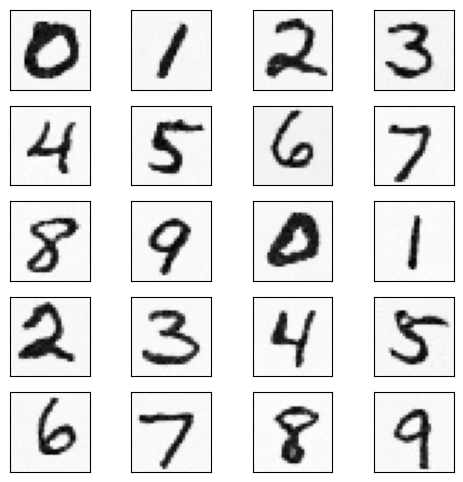

In [8]:
### Problem 2a: Ablation Study 1
n_T = 500
ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=10), betas=(1e-4, 0.02), n_T=n_T, \
    device=device, drop_prob=0.1)
ddpm.to(device)

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

optim = torch.optim.Adam(ddpm.parameters(), lr=lr)
train_main_loop(ddpm, optim, train_loader, lr, ws_test, n_epoch, batch_size)

epoch 0, loss: 0.0269
epoch 1, loss: 0.0208
epoch 2, loss: 0.0181
epoch 3, loss: 0.0173
epoch 4, loss: 0.0153
epoch 5, loss: 0.0160
epoch 6, loss: 0.0144
epoch 7, loss: 0.0144
epoch 8, loss: 0.0134
epoch 9, loss: 0.0140
Sampling timestep 1800
Sampling timestep 1600
Sampling timestep 1400
Sampling timestep 1200
Sampling timestep 1000
Sampling timestep 800
Sampling timestep 600
Sampling timestep 400
Sampling timestep 200
Sampling timestep 0


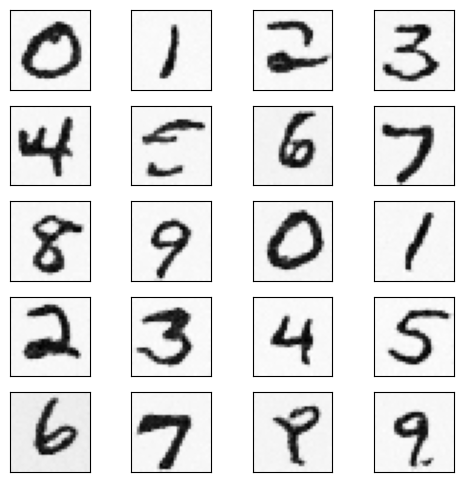

In [9]:
n_T = 2000
ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=10), betas=(1e-4, 0.02), n_T=n_T, \
    device=device, drop_prob=0.1)
ddpm.to(device)

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

optim = torch.optim.Adam(ddpm.parameters(), lr=lr)
train_main_loop(ddpm, optim, train_loader, lr, ws_test, n_epoch, batch_size)

epoch 0, loss: 0.0330
epoch 1, loss: 0.0262
epoch 2, loss: 0.0246
epoch 3, loss: 0.0219
epoch 4, loss: 0.0203
epoch 5, loss: 0.0208
epoch 6, loss: 0.0197
epoch 7, loss: 0.0190
epoch 8, loss: 0.0194
epoch 9, loss: 0.0180
Sampling timestep 0


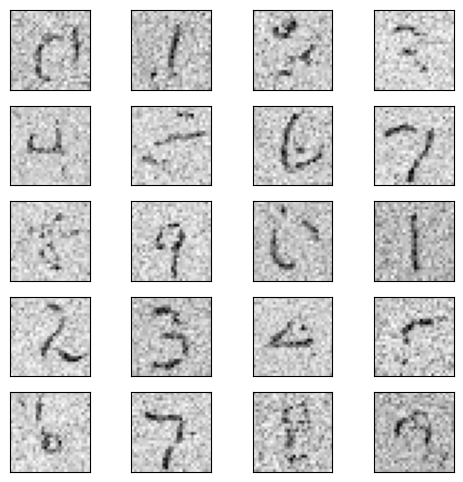

In [10]:
### Problem 2b: Ablation Study 2
n_T, n_inference = 1000, 100
ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=10), betas=(1e-4, 0.02), n_T=n_T, \
    device=device, n_inference=n_inference, drop_prob=0.1)
ddpm.to(device)

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

optim = torch.optim.Adam(ddpm.parameters(), lr=lr)
train_main_loop(ddpm, optim, train_loader, lr, ws_test, n_epoch, batch_size)

epoch 0, loss: 0.0335
epoch 1, loss: 0.0272
epoch 2, loss: 0.0245
epoch 3, loss: 0.0228
epoch 4, loss: 0.0215
epoch 5, loss: 0.0219
epoch 6, loss: 0.0205
epoch 7, loss: 0.0201
epoch 8, loss: 0.0185
epoch 9, loss: 0.0183
Sampling timestep 0


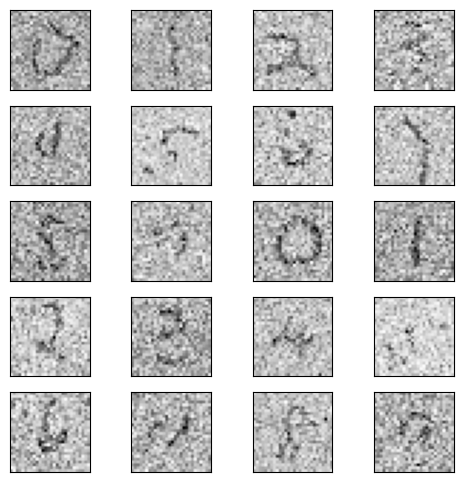

In [11]:
n_T, n_inference = 1000, 50
ddpm = DDPM(nn_model=ContextUnet(in_channels=1, n_feat=n_feat, n_classes=10), betas=(1e-4, 0.02), n_T=n_T, \
    device=device, n_inference=n_inference, drop_prob=0.1)
ddpm.to(device)

tf = transforms.Compose([transforms.ToTensor()]) # mnist is already normalised 0 to 1

optim = torch.optim.Adam(ddpm.parameters(), lr=lr)
train_main_loop(ddpm, optim, train_loader, lr, ws_test, n_epoch, batch_size)

# **3. Continuous-time Stochastic Process**

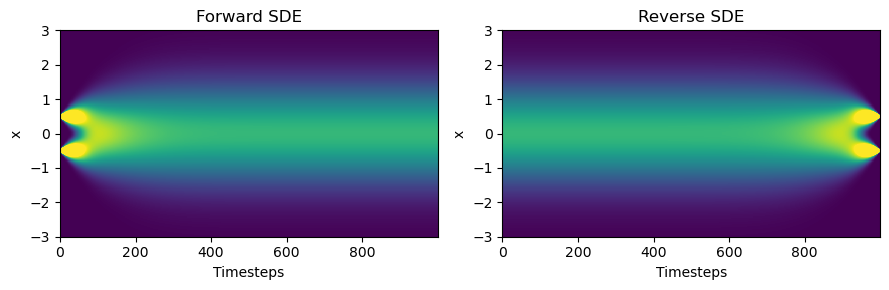

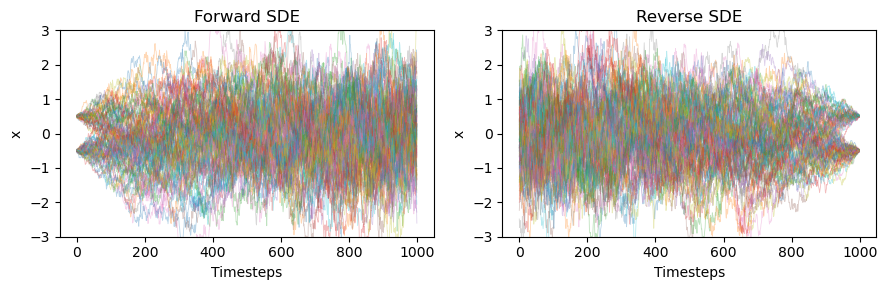

In [12]:
timesteps = 1000
beta1 = 0.1
beta2 = 50.0
dt = 1.0 / timesteps
means = np.array([0.5, -0.5])
stds = np.array([0.02, 0.02])
weights = np.array([0.5, 0.5])
weights /= np.sum(weights)
n_samples = 100
x_min = -3
x_max = 3
x_grid = np.linspace(x_min, x_max, num=200)

def get_beta_t(t):
    ratio = float(t) / timesteps
    return ratio * beta2 + (1 - ratio) * beta1

def f(x, t):
    beta_t = get_beta_t(t)
    return -0.5 * beta_t * x

def g(t):
    beta_t = get_beta_t(t)
    return np.sqrt(beta_t)

def gaussian_pdf(x, mean, std):
    return (1.0 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

def mixture_pdf(x):
    pdf = np.zeros_like(x)
    for i in range(len(means)):
        pdf += weights[i] * gaussian_pdf(x, means[i], stds[i])
    return pdf

def sample_mixture_gaussian(n_samples):
    components = np.random.choice(len(means), size=n_samples, p=weights / np.sum(weights))
    samples = np.random.normal(loc=means[components], scale=stds[components])
    return samples

def p_xt(x_t, t):
    ##################
    ### Problem 3(a): p(x(t))
    tau = t / timesteps
    SIGMA = 1 - np.exp(-0.5 * tau ** 2 * (beta2 - beta1) - tau * beta1) # actually SIGMA^2

    sigma_t = np.sqrt(SIGMA + stds ** 2 - SIGMA * (stds ** 2))
    A = 1 / (np.sqrt(2 * np.pi) * sigma_t)
    mu_t = means * np.sqrt(1 - SIGMA)
    p_xt_val = np.sum(A * np.exp(-0.5 * ((x_t.reshape(-1, 1) - mu_t.reshape(1, -1)) ** 2) / sigma_t ** 2) \
        * weights.reshape(1,-1), axis=1)
    ##################
    ##################
    return p_xt_val

def grad_log_p_xt(x_t, t):
    ##################
    ### Problem 3(b): \nabla_x(t) \log p(x(t))
    tau = t / timesteps
    SIGMA = 1 - np.exp(-0.5 * tau ** 2 * (beta2 - beta1) - tau * beta1) # actually SIGMA^2

    sigma_t = np.sqrt(SIGMA + stds ** 2 - SIGMA * (stds ** 2))
    mu_t = (means * np.sqrt(1 - SIGMA))

    A = 1 / (np.sqrt(2 * np.pi) * sigma_t)
    diff = x_t.reshape(-1, 1) - mu_t.reshape(1, -1)  # (n_samples, n_means)
    pdf_vals = A * np.exp(-0.5 * (diff ** 2) / (sigma_t ** 2))
    # final expression
    numerator = np.sum(pdf_vals * (-diff / (sigma_t ** 2)) * weights.reshape(1, -1), axis=1)
    denominator = np.sum(pdf_vals * weights.reshape(1, -1), axis=1)

    grad_log = numerator / (denominator + 1e-8)
    return grad_log
    ##################
    ##################

def forward_sde(timesteps, n_samples, dt):
    x = np.zeros((timesteps, n_samples))

    x_pdf = np.zeros((timesteps, x_grid.shape[0]))

    x0 = sample_mixture_gaussian(n_samples)
    x0_pdf = mixture_pdf(x_grid)
    x[0] = x0
    x_pdf[0] = x0_pdf

    for t in range(1, timesteps):
        noise = np.random.normal(0, 1, size=n_samples)
        x[t] = x[t-1] + f(x[t-1], t) * dt + g(t) * noise * np.sqrt(dt)
        x_pdf[t] = p_xt(x_grid, t)

    return x, x_pdf

def backward_sde(timesteps, n_samples, dt):
    x = np.zeros((timesteps, n_samples))
    xT = np.random.normal(0, 1, size=n_samples)
    x[-1] = xT

    for t in range(timesteps - 1, 0, -1):
        noise = np.random.normal(0, 1, size=n_samples)
        delta_x = (f(x[t], t) - g(t) ** 2 * grad_log_p_xt(x[t], t)) * dt + g(t) * noise * np.sqrt(dt)
        x[t-1] = x[t] - delta_x

    return x

forward_x, forward_x_pdf = forward_sde(timesteps, n_samples, dt)
backward_data = backward_sde(timesteps, n_samples, dt)

# PDF evolution
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

time = np.arange(timesteps)
X, Y = np.meshgrid(time, x_grid)
pcm = axes[0].pcolormesh(X, Y, forward_x_pdf.T,
                         cmap='viridis', shading='auto', vmin=0.0, vmax=0.6)
axes[0].set_title('Forward SDE')
axes[0].set_xlabel('Timesteps')
axes[0].set_ylabel('x')
axes[0].set_ylim([x_min, x_max])

X, Y = np.meshgrid(time, x_grid)
pcm = axes[1].pcolormesh(X, Y, forward_x_pdf[::-1].T,
                         cmap='viridis', shading='auto', vmin=0.0, vmax=0.6)
axes[1].set_title('Reverse SDE')
axes[1].set_xlabel('Timesteps')
axes[1].set_ylabel('x')
axes[1].set_ylim([x_min, x_max])

plt.tight_layout()
plt.show()

# trajectories
fig, axes = plt.subplots(1, 2, figsize=(9, 3))

for i in range(n_samples):
    axes[0].plot(forward_x[:, i], lw=0.6, alpha=0.3)

time = np.arange(timesteps)
X, Y = np.meshgrid(time, x_grid)
axes[0].set_title('Forward SDE')
axes[0].set_xlabel('Timesteps')
axes[0].set_ylabel('x')
axes[0].set_ylim([x_min, x_max])

for i in range(n_samples):
    axes[1].plot(backward_data[::-1][:, i], lw=0.6, alpha=0.3)

X, Y = np.meshgrid(time, x_grid)
axes[1].set_title('Reverse SDE')
axes[1].set_xlabel('Timesteps')
axes[1].set_ylabel('x')
axes[1].set_ylim([x_min, x_max])

plt.tight_layout()
plt.show()
